# Mountain cart

This is the notebook for the implement the mountain cart problem. 
It is divided into:
1. Random Agent
2. DQN approach
3. DQN with auxiliary function
4. DQN with RND

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

# **1.** Random Agent

In [25]:
from RandomAgent import RandomAgent

env = gym.make('MountainCar-v0')#, render_mode = "human")
agent = RandomAgent(env)
num_episodes = 100

rewards = []
durations=[]
for episode in tqdm(range(num_episodes)):
    t0 = time()
    seed = np.random.randint(0, 100000)
    state = env.reset(seed=seed)
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        agent.observe(state, action, next_state, reward)
        agent.update()
        total_reward += reward
        state = next_state
        done = terminated or truncated
    t1 = time()
    durations.append(t1-t0)
    rewards.append(total_reward)

100%|██████████| 100/100 [00:01<00:00, 51.16it/s]


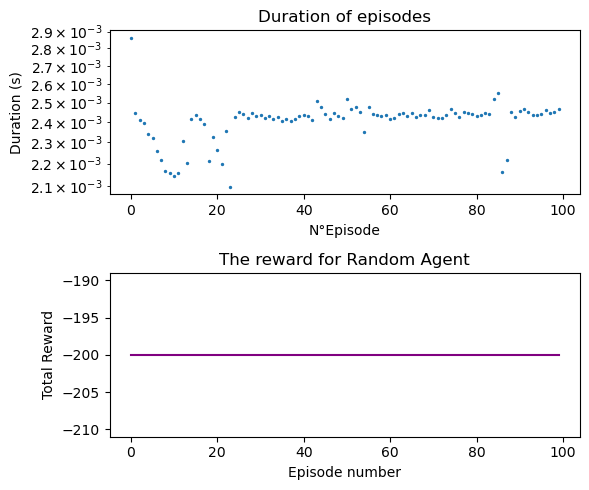

In [26]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))

# Scatter plot
ax1.scatter(range(num_episodes), durations, s=2)
ax1.set_yscale('log')
ax1.set_xlabel('N°Episode')
ax1.set_ylabel('Duration (s)')
ax1.set_title('Duration of episodes')

# Line plot
ax2.plot(rewards, color="purple")
ax2.set_title("The reward for Random Agent")
ax2.set_ylabel("Total Reward")
ax2.set_xlabel("Episode number")

plt.tight_layout()
plt.savefig("plots/RandomAgent.png")
plt.show()



# **2.** DQN Agent

100%|██████████| 1000/1000 [01:34<00:00, 10.53it/s]


Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes/


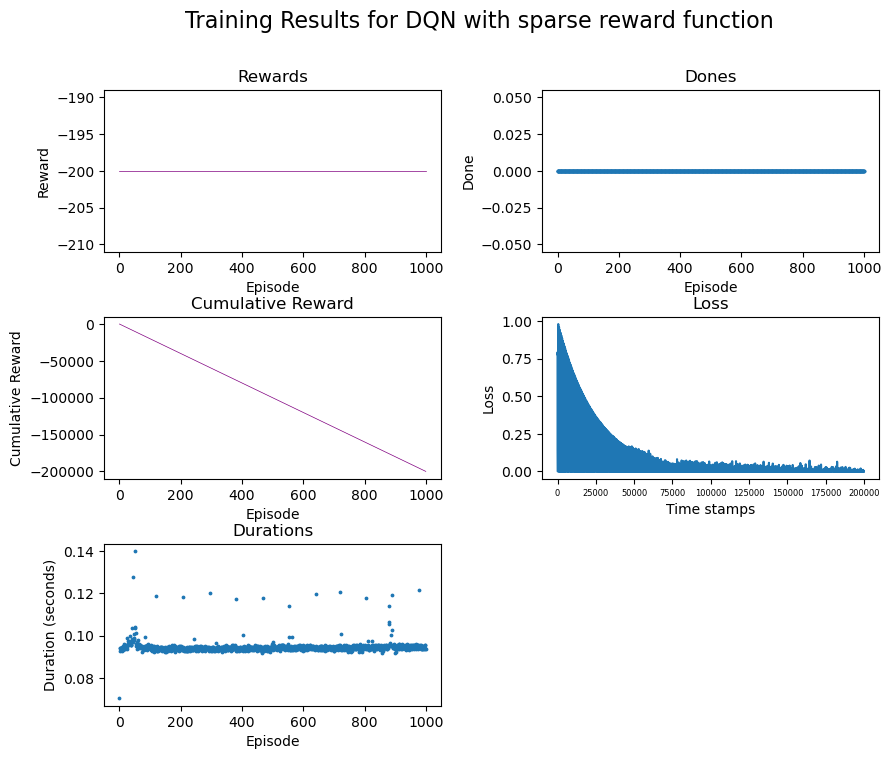

In [100]:
from DQN import DQNAgent

num_episodes = 1000
reward_function = "-1"

env = gym.make('MountainCar-v0') #, render_mode = "human"
state_size, action_size = env.observation_space.shape[0], env.action_space.n
agent = DQNAgent(env, state_size, action_size)
agent.train(env, agent, num_episodes)
agent.save_agent(f"DQN_{num_episodes}_episodes")
agent.sparse_plots()

# **2.1** Auxiliary Reward for DQN

In [70]:
import numpy as np

def calculate_reward(position, done, step_penalty=10, C=10, D=5):
    goal_position = 0.5   # position of the goal
    min_position = -1.2   # leftmost position
    
    # Normalize the position to be between 0 and 1, where 1 is the goal
    norm_position = (position - min_position) / (goal_position - min_position)

    # Calculate the position-based reward component (proximity to goal)
    position_reward = -C * (1 - norm_position)  # Less negative as it approaches the goal
    
    # Calculate the height-based reward component
    height = np.cos(np.pi * position - np.pi/1.5 + 0.3)
    height_reward = -D * (1 - height)  # Less negative as the cart climbs higher
    
    # Total reward combines position reward, height reward, and a time penalty
    total_reward = position_reward + height_reward
    if not done:
        total_reward -= step_penalty

    return total_reward


In [79]:
import gymnasium as gym
import numpy as np
from typing import Optional

# modify the environment class by inheriting the gymnasium environment class of the mountain cart, and changing the step() function such that the reward is always 1
class MountainCarReward1(gym.Env):
    def __init__(self, C=100, D=50, step_penalty = 10, aux_factor = 1, render_mode: Optional[str] = None):
        self.render_mode = render_mode
        self.env = gym.make('MountainCar-v0', render_mode=render_mode)
        self.action_space = self.env.action_space
        self.observation_space = self.env.observation_space
        self.reward_range = self.env.reward_range
        self.number_steps = 0
        self.C = C
        self.D = D
        self.step_penalty = step_penalty
        self.aux_factor = aux_factor
        self.reward_function = "complex"

    def step(self, action: int):
        assert self.action_space.contains(action), f"{action!r} ({type(action)}) invalid"
        state, reward, done, truncated, _ = self.env.step(action)
        self.number_steps += 1
        aux_reward = calculate_reward(state[0], done, step_penalty=self.step_penalty, C=self.C, D=self.D)

        if self.number_steps == 200:
            truncated = True

        final_reward = reward + aux_reward * self.aux_factor
        self.reward = reward
        self.aux_reward = aux_reward
        self.final_reward = final_reward

        return np.array(state, dtype=np.float32), final_reward, done, truncated, {}
    
    def get_decomposed_rewards(self):
        return self.reward, self.aux_reward, self.final_reward

    def reset(self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
        ):
        self.number_steps = 0
        return self.env.reset(seed=seed, options=options)

    def render(self, render_mode='human'):
        return self.env.render(render_mode=render_mode)

    def close(self):
        return self.env.close()

* + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + 
Training DQN for 3000 episodes with reward function: complex and aux factor of: 1
 



100%|██████████| 3000/3000 [03:20<00:00, 14.94it/s]


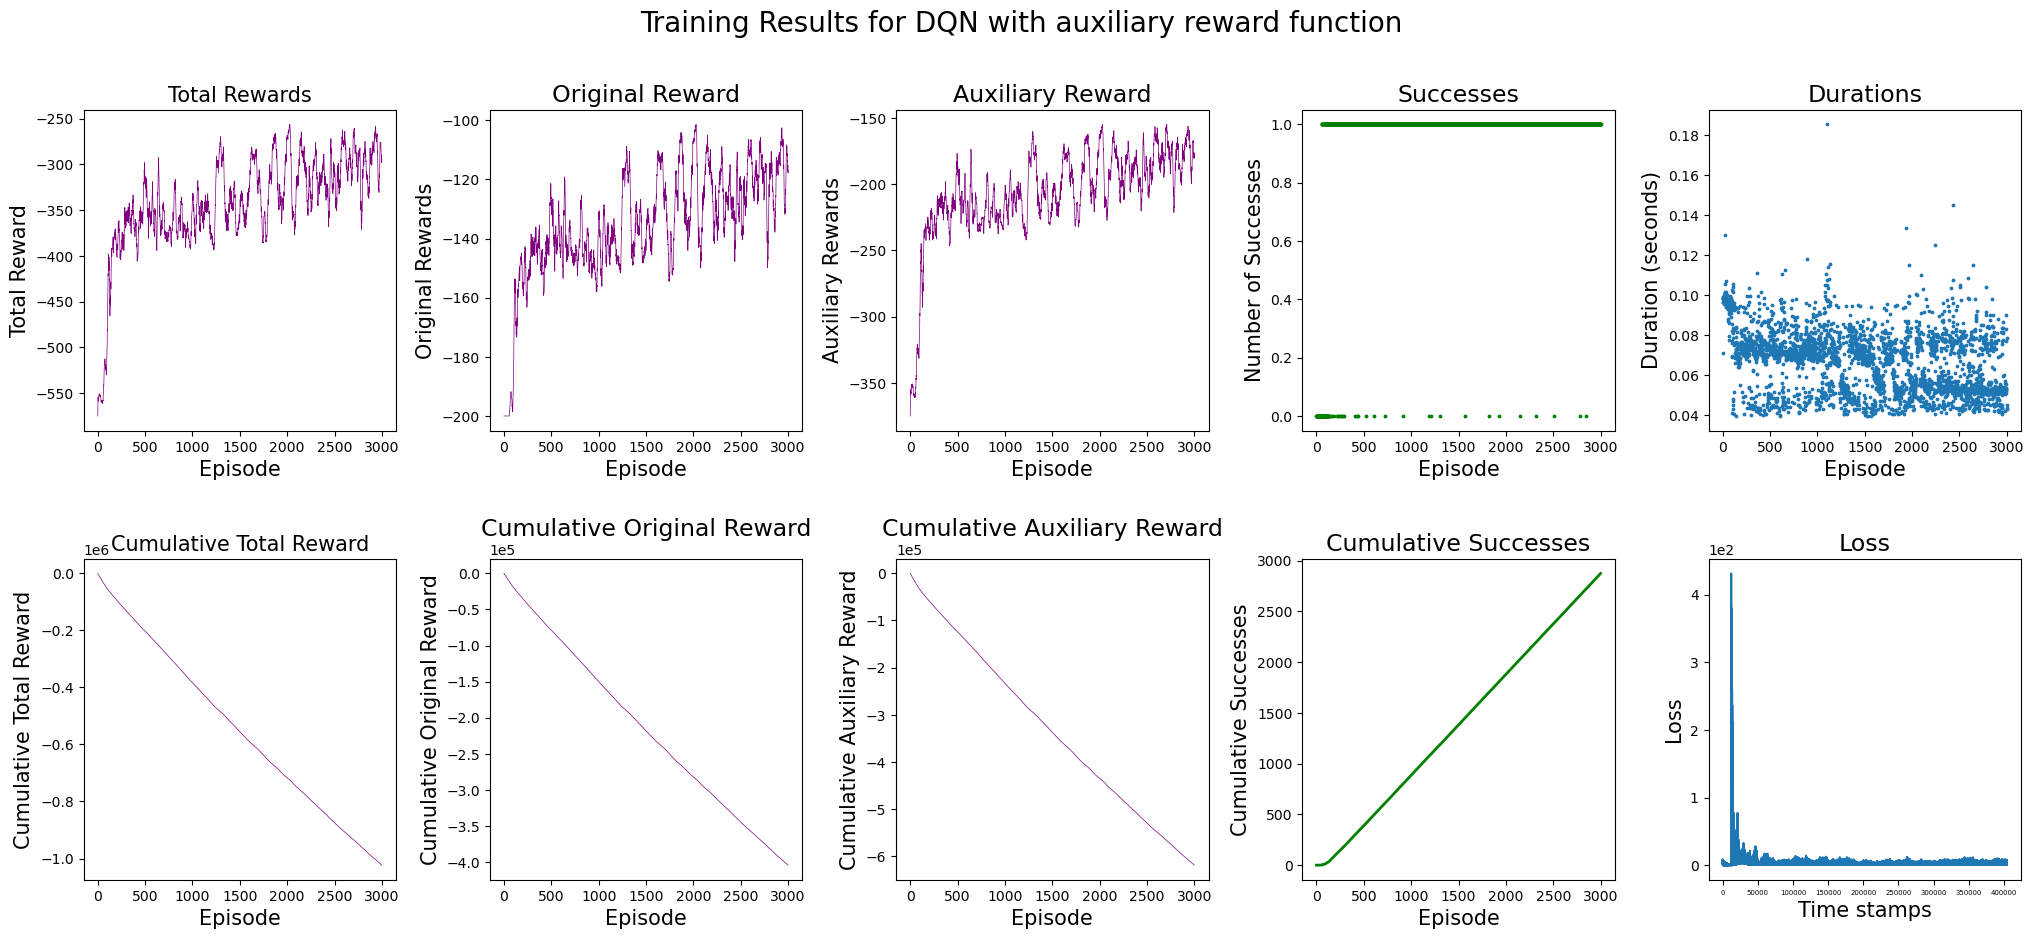

<Figure size 640x480 with 0 Axes>

In [93]:
from DQN import DQNAgent

num_episodes = 3000
reward_function = "complex"

aux_list = [0]

for auxfact in aux_list:
    print("* + "*20)
    print(f"Training DQN for {num_episodes} episodes with reward function: {reward_function} and aux factor of: {auxfact}\n \n")
    env = MountainCarReward1(render_mode=None, C = 1, D = 0.5, step_penalty=0.3, aux_factor = auxfact)
    state_size, action_size = env.observation_space.shape[0], env.action_space.n
    agent = DQNAgent(env, state_size, action_size,target_update_frequency = 100, reward_function=reward_function)
    agent.train(env, agent, num_episodes)
    agent.reward_plot()

In [94]:
agent.save_agent(f"DQN_{num_episodes}_episodes_{reward_function}aux")

Directory created:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_complexaux/
Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_complexaux/


# **3.4** DQN with RND

* + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + * + 
Training DQN for 3000 episodes with reward factor: 700
 

Agent loaded from path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_reward_factor_700/


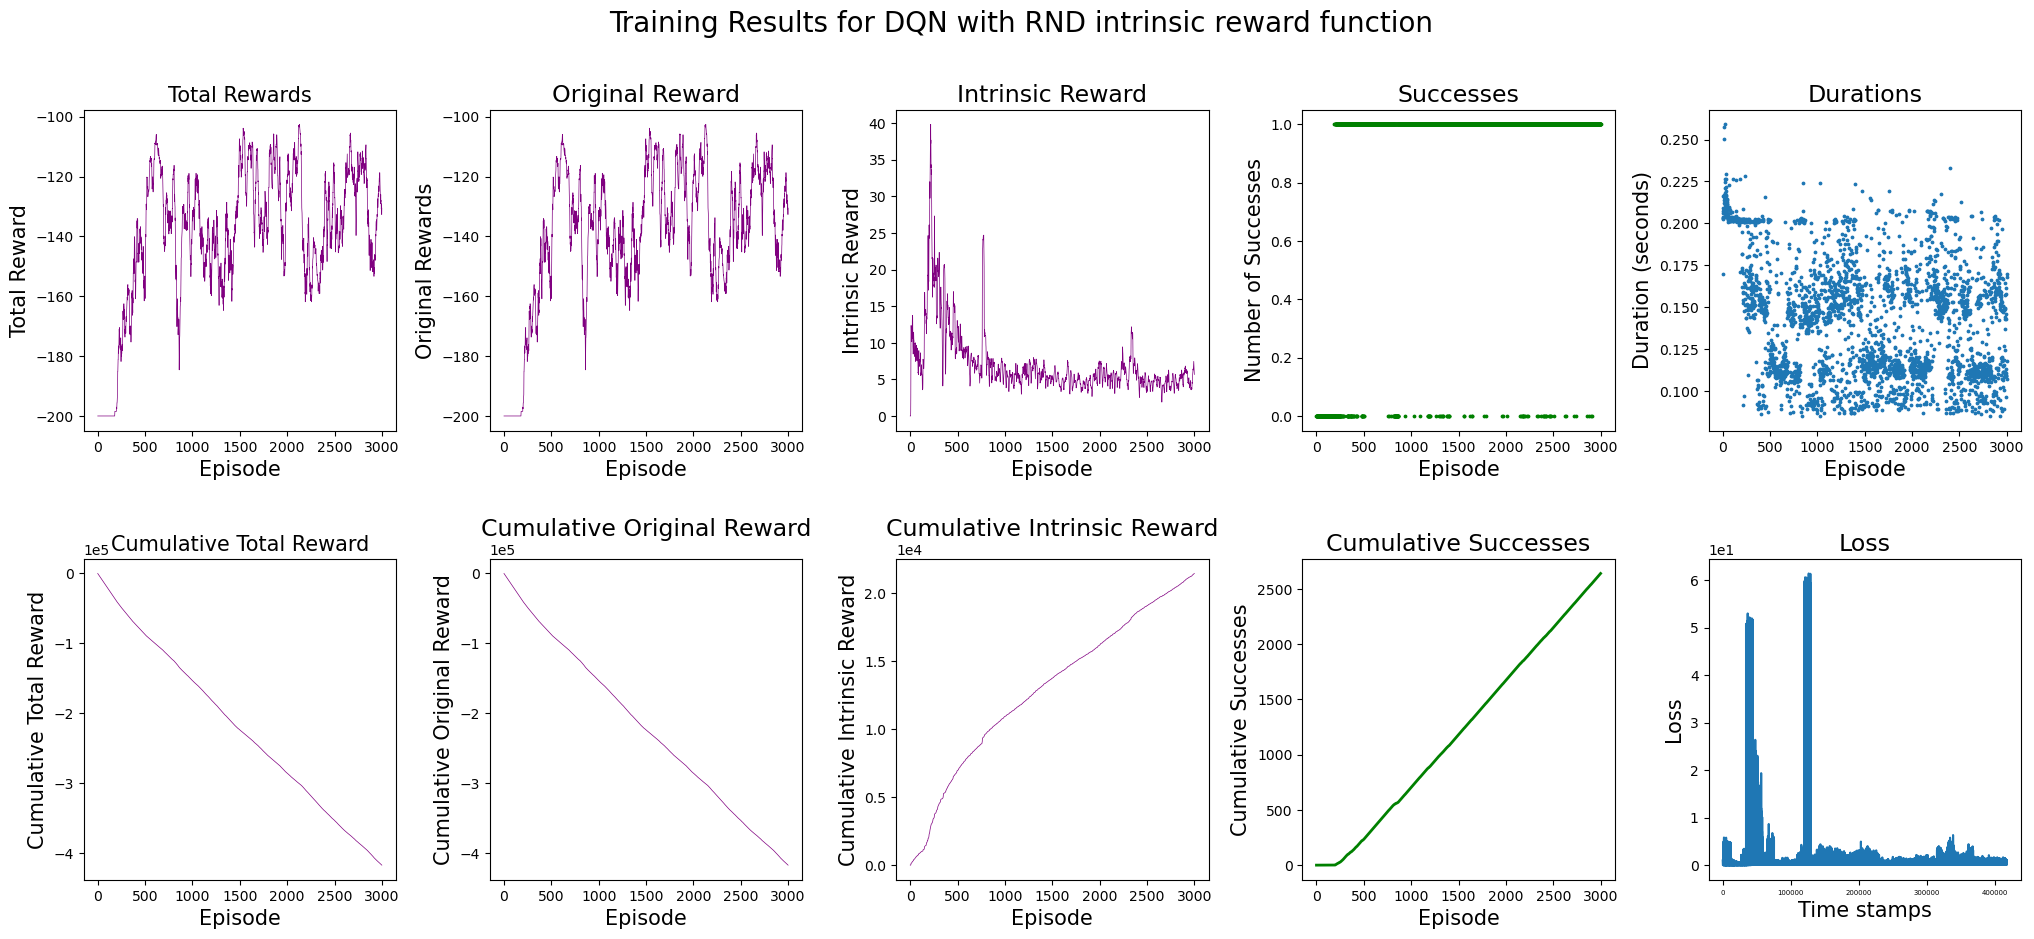

<Figure size 640x480 with 0 Axes>

In [97]:
import gymnasium as gym
from DQN import *

# Define your environment here
env = gym.make("MountainCar-v0")

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
num_episodes = 3000

reward_factors = [700]
train = False

for reward_factor in reward_factors:
    print("* + "*20)
    print(f"Training DQN for {num_episodes} episodes with reward factor: {reward_factor}\n \n")
    agent = DQNAgent(
        env=env,
        state_size=state_size,
        action_size=action_size,
        gamma=0.99,
        min_epsilon=0.05,
        max_epsilon=0.9,
        decay_epsilon=0.995,
        replay_buffer_max=10000,
        batch_size=64,
        learning_rate=0.001,
        hidden_layer_sizes=[64, 64],
        target_update_frequency=500,
        reward_factor=reward_factor,
        rnd = True,
    )

    if train:
        rewards = agent.train(env, agent, num_episodes=num_episodes)
        agent.save_agent(f"DQN_{num_episodes}_episodes_reward_factor_{reward_factor}")
    else:
        agent.load_agent(f"DQN_{num_episodes}_episodes_reward_factor_{reward_factor}")
    agent.reward_plot()

# 4 DYNA

In [3]:
from DYNA import *

In [5]:
env = gym.make('MountainCar-v0')
retrain=False
if retrain:
    dyna_agent=DynaAgent(env)
    #train the agent
    dyna_agent.training(3000)
else:
    #load agent
    with open("agents_saved/dyna_agent_final.pkl", 'rb') as f:
        dyna_agent = pickle.load(f)

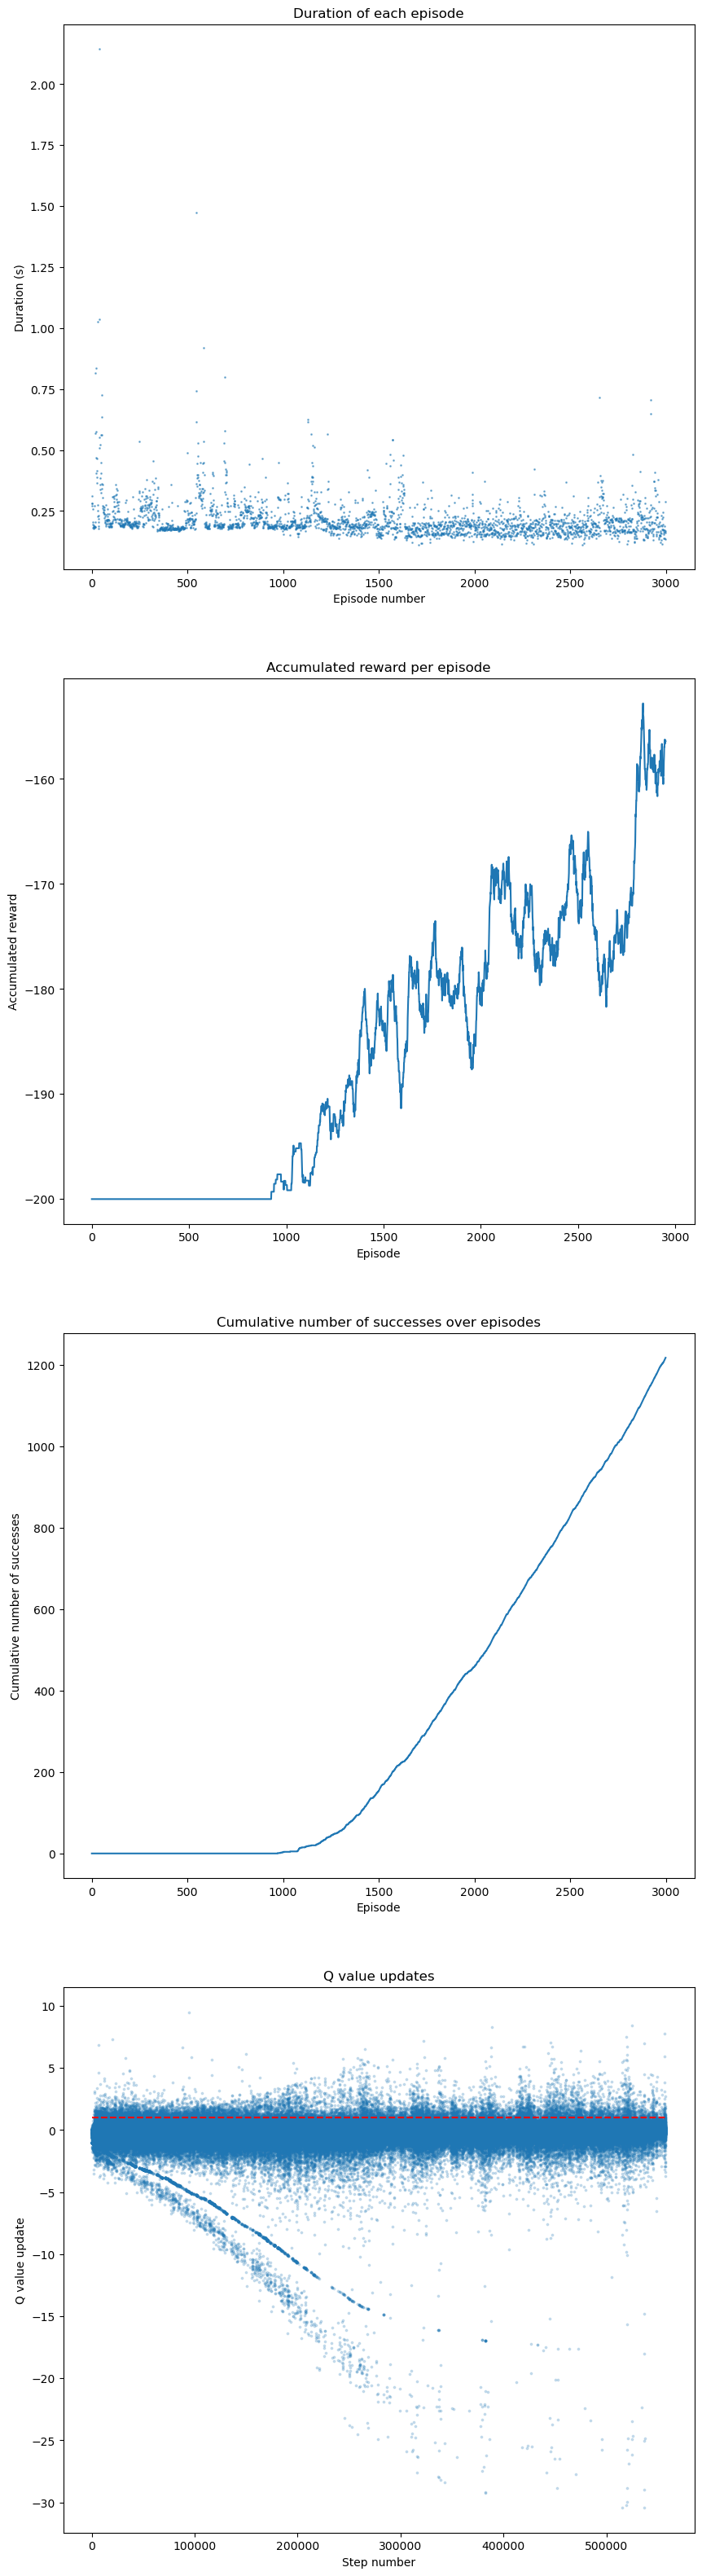

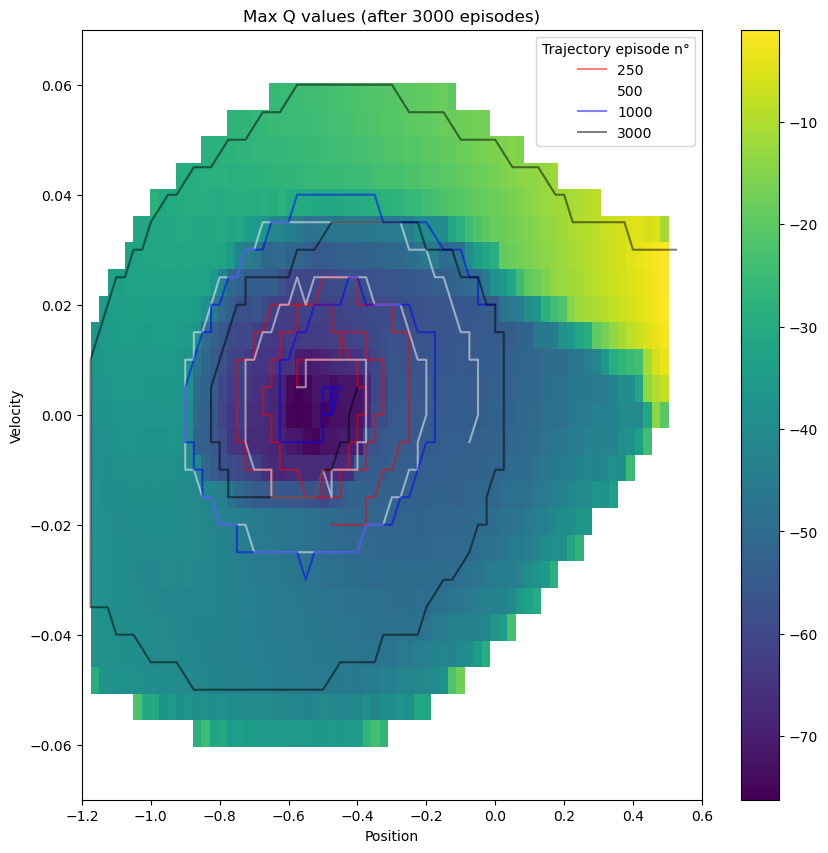

In [4]:
plot_all_on_same_column(dyna_agent)

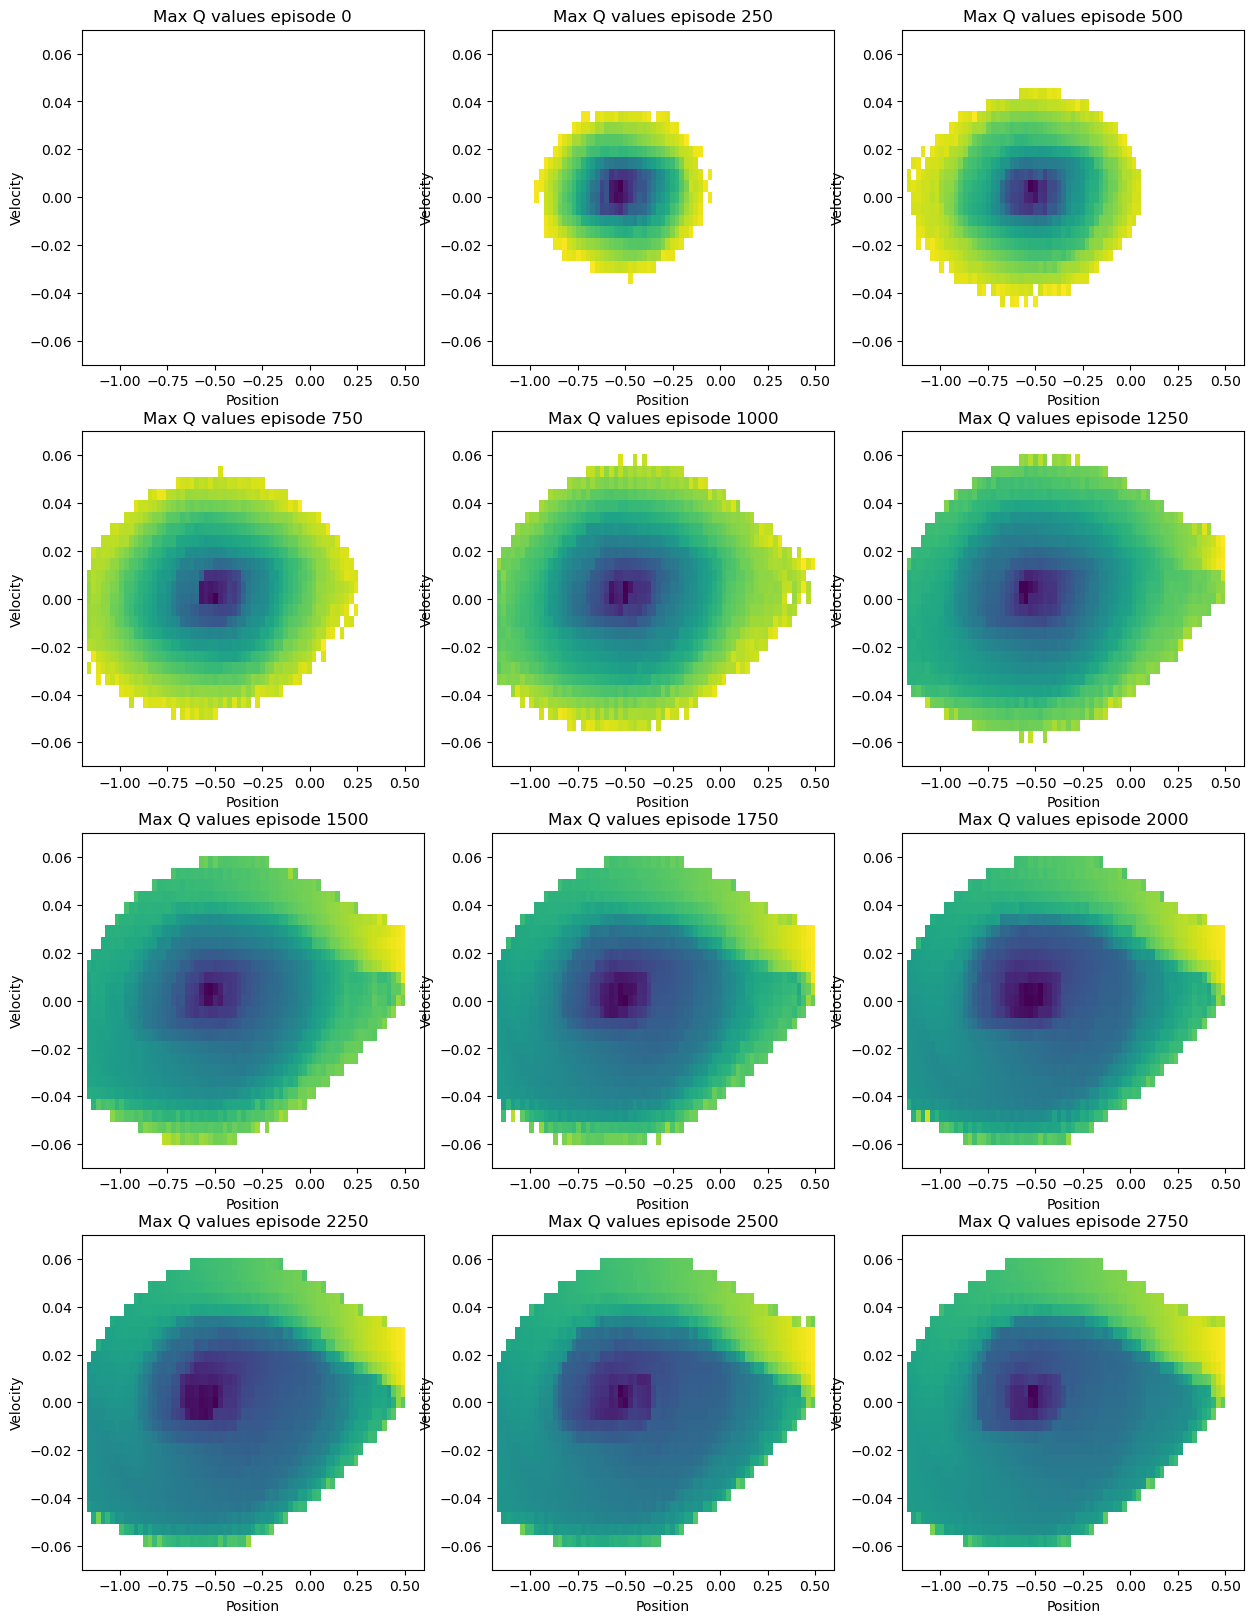

In [5]:
plot_max_q_at_different_episodes(dyna_agent)

The accumulated reward per episode plot is smoothed using a window of size 50

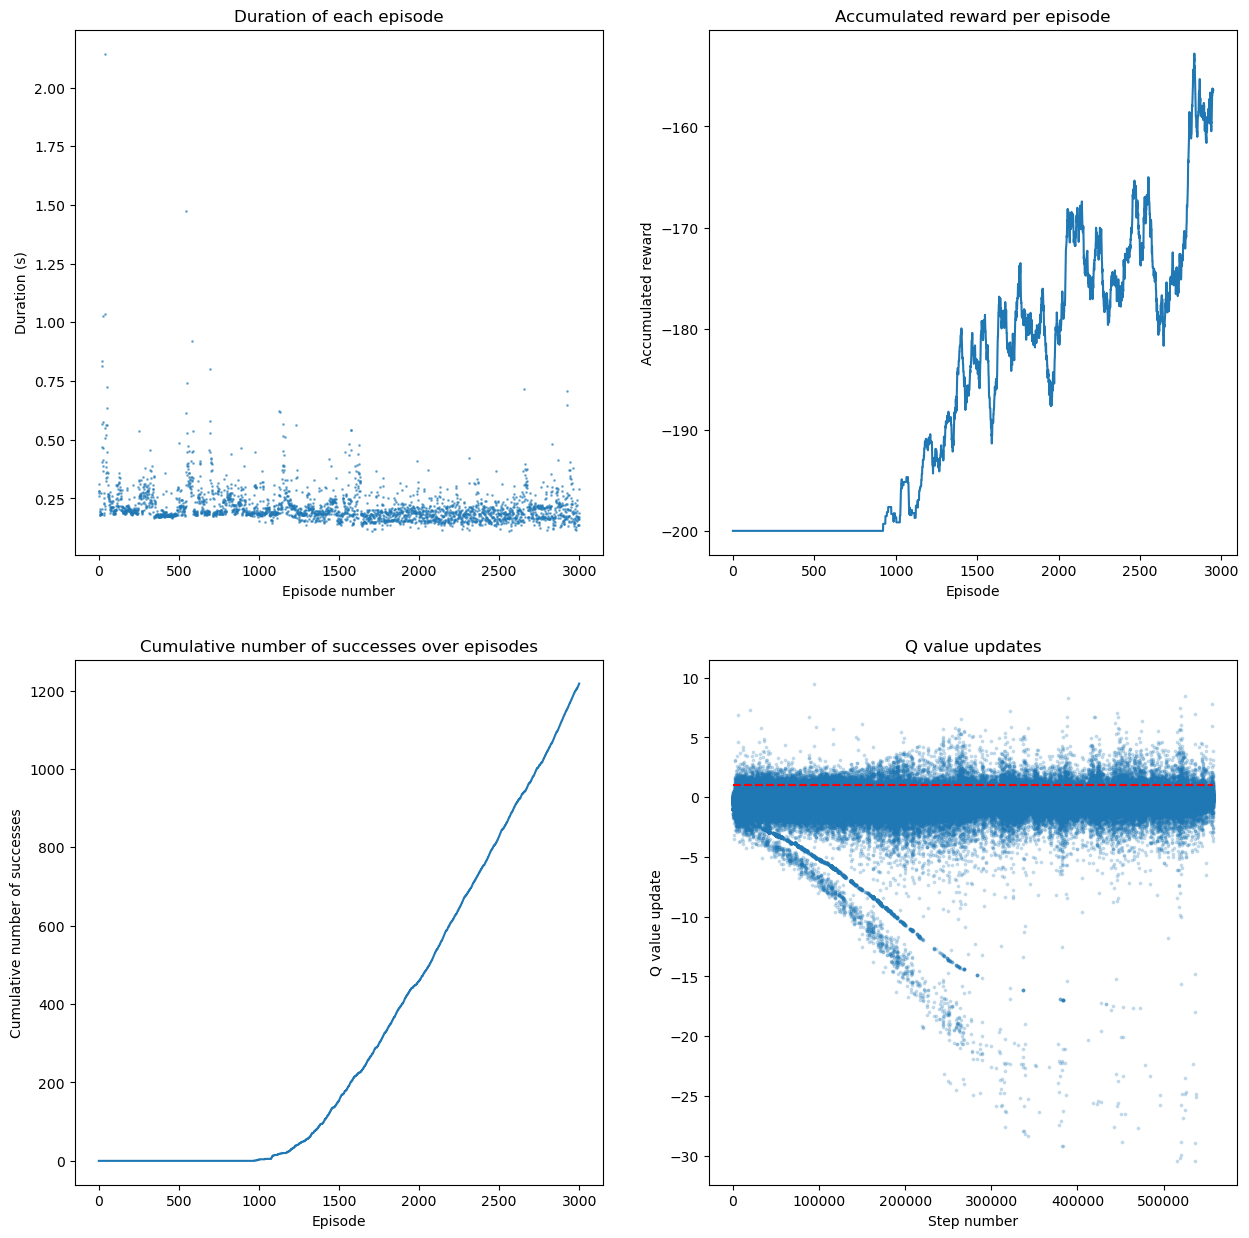

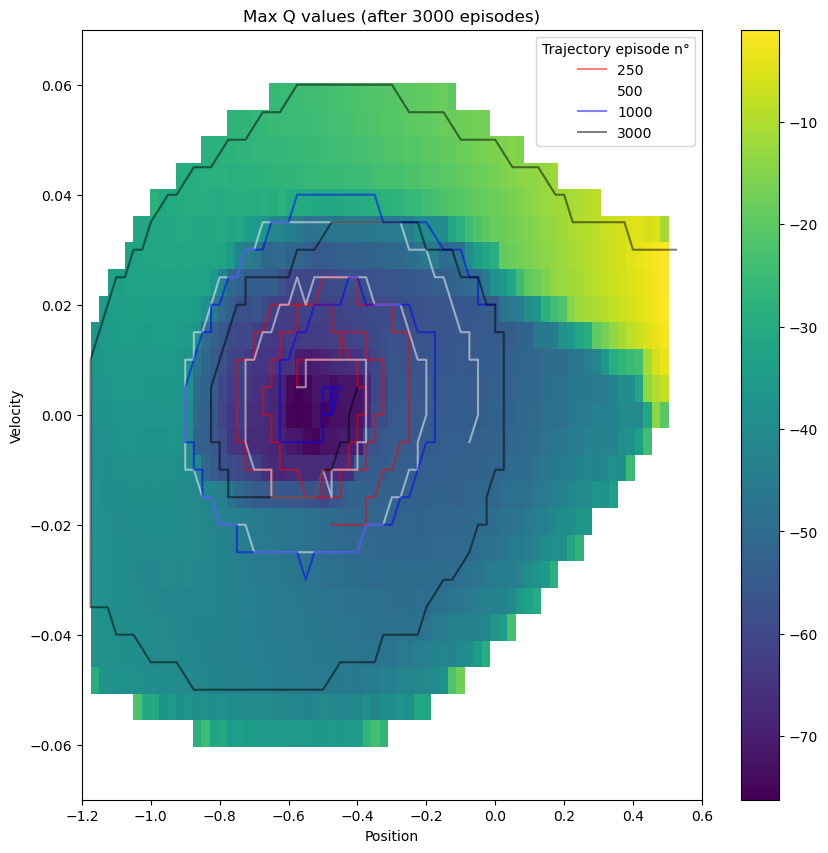

In [6]:
plot_all_on_same_figure(dyna_agent)

In [12]:
sucesss,rewards_dyna=inference_test(dyna_agent,1000,return_rewards=True)

100%|██████████| 1000/1000 [00:17<00:00, 58.10it/s]

Proportion of successful episodes: 79.4 %


In [13]:
np.save("test_rewards_dyna.npy",rewards_dyna)

## 4.1 Influence of discretization

### Small bins

In [6]:
dyna_small=DynaAgent(env,size_bin_x=0.0125,size_bin_y=0.0025)
retrain=False
if retrain:
    dyna_small.training(3000,reset=True,render=False)
else:
    with open("agents_saved/dyna_small.pkl", 'rb') as f:
        dyna_small = pickle.load(f)

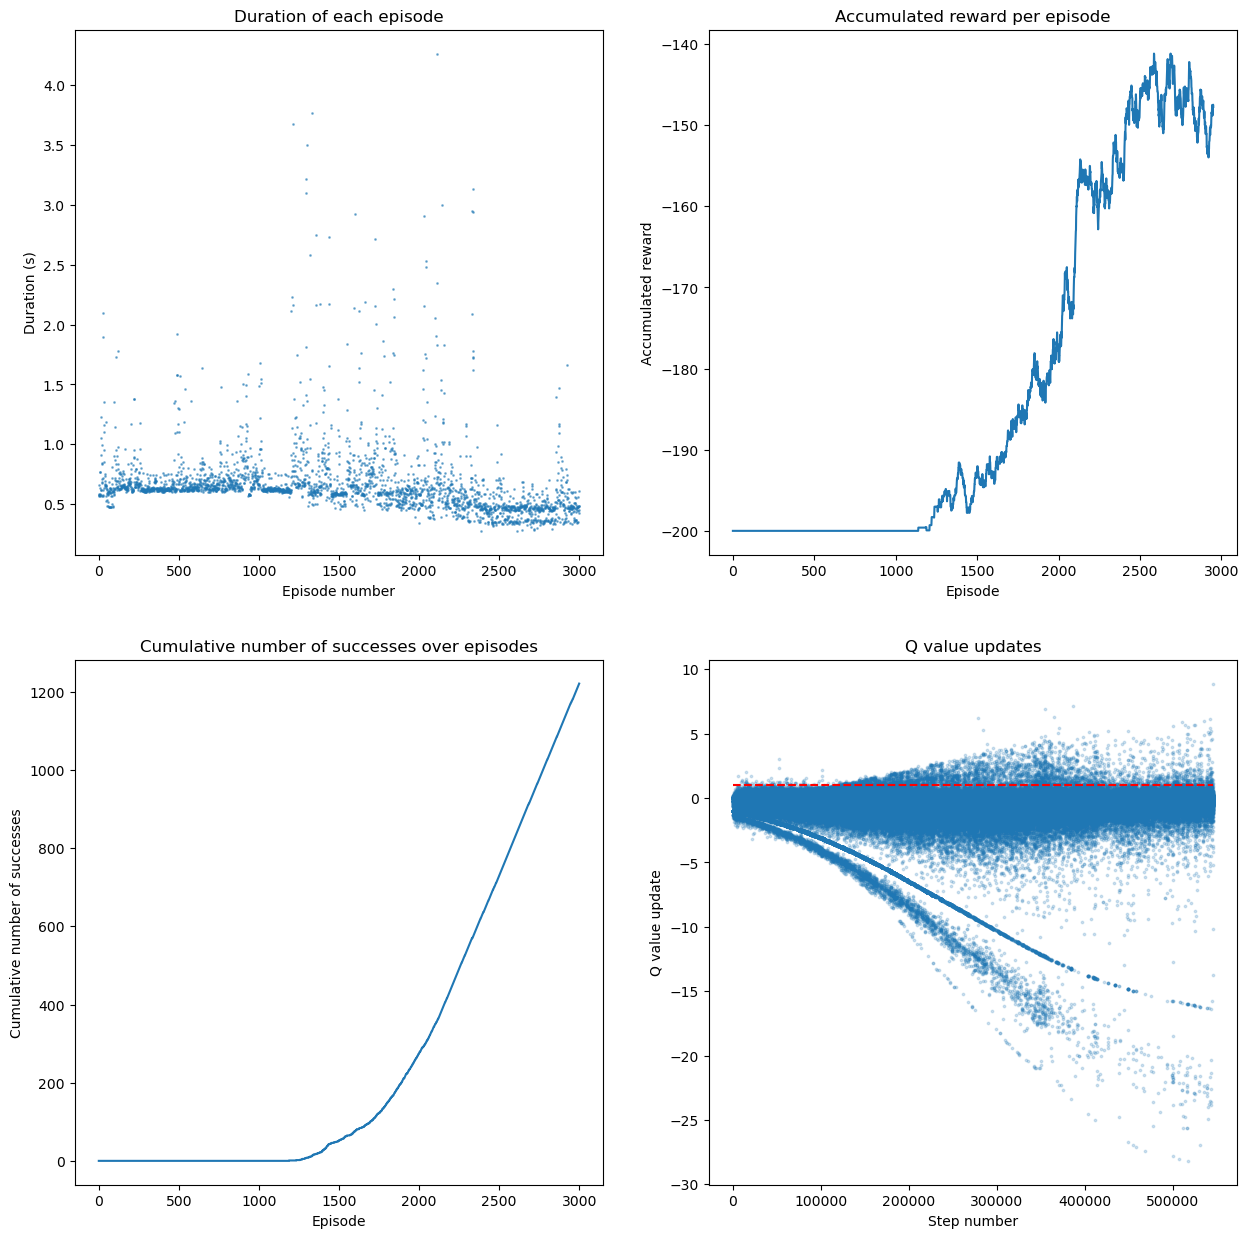

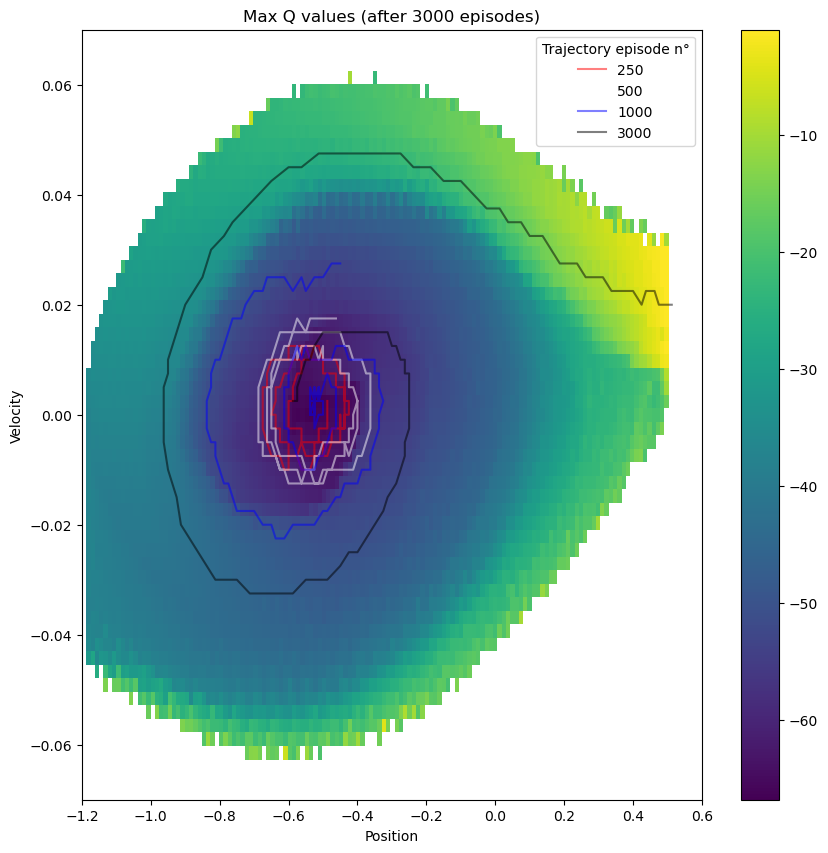

In [15]:
plot_all_on_same_figure(dyna_small)

In [16]:
inference_test(dyna_small,1000)

100%|██████████| 1000/1000 [00:36<00:00, 27.43it/s]

Proportion of successful episodes: 99.3 %


0.993

### Big bins

In [ ]:
dyna_big=DynaAgent(env,size_bin_x=0.05,size_bin_y=0.01)
retrain=True
save=True
if retrain:
    dyna_big.training(3000,reset=True,render=False)
    if save:
        with open("agents_saved/dyna_big.pkl", 'wb') as f:
            pickle.dump(dyna_big, f)
else:
    with open("agents_saved/dyna_big.pkl", 'rb') as f:
        dyna_big = pickle.load(f)

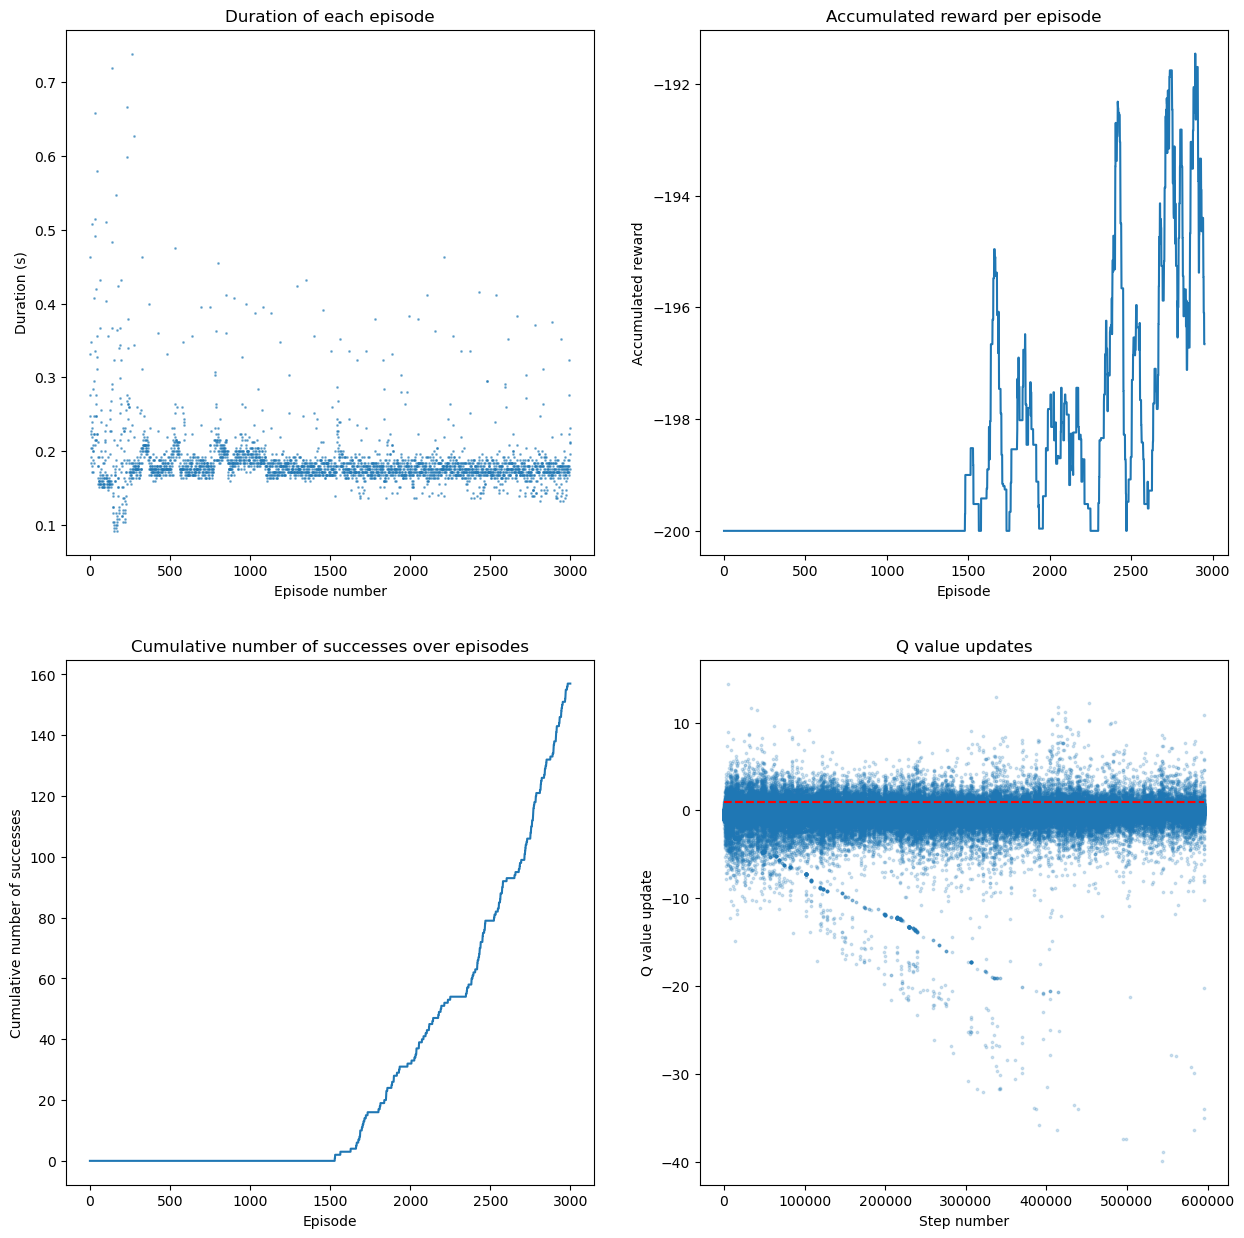

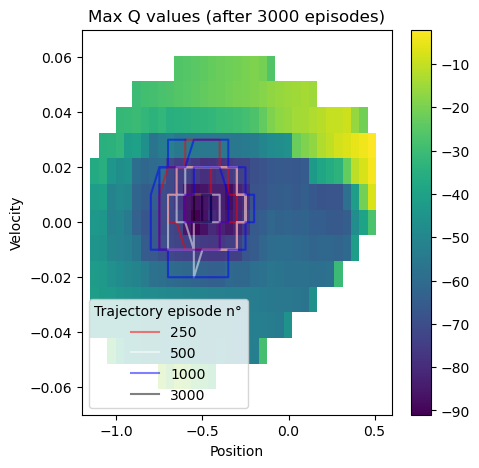

In [29]:
plot_all_on_same_figure(dyna_big)

In [30]:
inference_test(dyna_big,1000)

100%|██████████| 1000/1000 [00:39<00:00, 25.43it/s]

Proportion of successful episodes: 55.50000000000001 %


0.555

# Comparison DQN - DYNA

Agent loaded from path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes/
Agent loaded from path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_complexaux/
Agent loaded from path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes/
Agent loaded from path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_complexaux/
Agent loaded from path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_reward_factor_700/


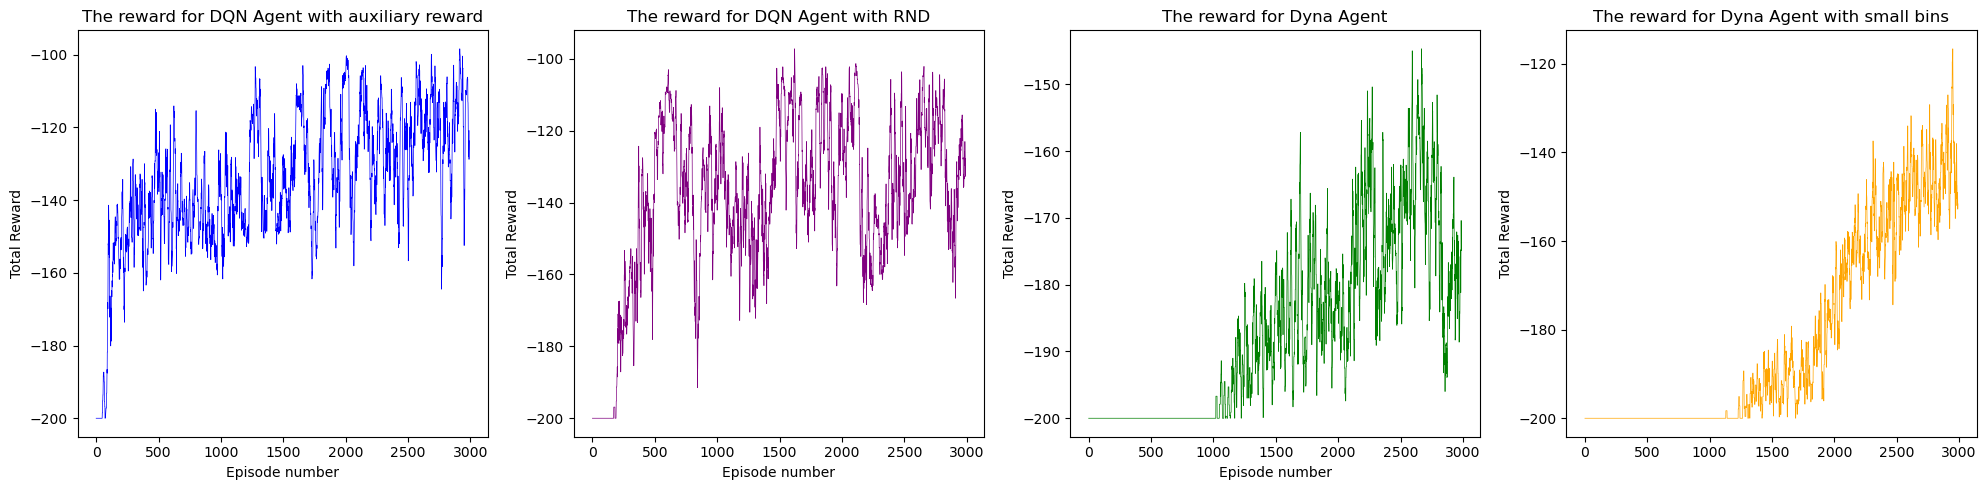

In [164]:
# training rewards plot

from DQN import DQNAgent, DQNnetwork

num_episodes = 1000
sample_seeds = [np.random.randint(0, 100000) for _ in range(1000)]

env = gym.make('MountainCar-v0') #, render_mode = "human"
state_size, action_size = env.observation_space.shape[0], env.action_space.n


# DQNAgent
agent = DQNAgent(env, state_size, action_size)
agent.load_agent(f"DQN_1000_episodes")

# DQNAgent with aux reward
env_aux = MountainCarReward1(render_mode=None, C = 100, D = 50, step_penalty=30, aux_factor = 0.05)
agent_aux = DQNAgent(env_aux, state_size, action_size)
agent_aux.load_agent(f"DQN_3000_episodes_complexaux")

# DQNRNDAgent# training rewards plot

from DQN import DQNAgent, DQNnetwork

num_episodes = 1000
sample_seeds = [np.random.randint(0, 100000) for _ in range(1000)]

env = gym.make('MountainCar-v0') #, render_mode = "human"
state_size, action_size = env.observation_space.shape[0], env.action_space.n

# DQNAgent
agent = DQNAgent(env, state_size, action_size)
agent.load_agent(f"DQN_1000_episodes")

# DQNAgent with aux reward
env_aux = MountainCarReward1(render_mode=None, C = 100, D = 50, step_penalty=30, aux_factor = 0.05)
agent_aux = DQNAgent(env_aux, state_size, action_size)
agent_aux.load_agent(f"DQN_3000_episodes_complexaux")

# DQNRNDAgent
agent_rnd = DQNAgent(env, state_size, action_size)
agent_rnd.load_agent("DQN_3000_episodes_reward_factor_700")

# plot the reward of agent
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

rewards = np.load("agents_saved/DQN_3000_episodes_complexaux/original_rewards.npy")
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[0].plot(rewards, color="blue", linewidth=0.5)
axs[0].set_title("The reward for DQN Agent with auxiliary reward")
axs[0].set_ylabel("Total Reward")
axs[0].set_xlabel("Episode number")

rewards = np.load("agents_saved/DQN_3000_episodes_reward_factor_700/original_rewards.npy")
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[1].plot(rewards, color="purple", linewidth=0.5)
axs[1].set_title("The reward for DQN Agent with RND")
axs[1].set_ylabel("Total Reward")
axs[1].set_xlabel("Episode number")

# load dyna
rewards = np.load("dyna_cumulative_reward_per_episode.npy")
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[2].plot(rewards_dyna, color="green", linewidth=0.5,label="DYNA")
axs[2].set_title("The reward for Dyna Agent")
axs[2].set_ylabel("Total Reward")
axs[2].set_xlabel("Episode number")

# load small dyna
rewards = np.load("/Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/dyna_small_cumulative_reward_per_episode.npy")
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[3].plot(rewards, color="orange", linewidth=0.5,label="DYNA small")
axs[3].set_title("The reward for Dyna Agent with small bins")
axs[3].set_ylabel("Total Reward")

plt.tight_layout()



In [165]:
# comparing the testing performance on 1000 new episodes, each one initialized with a randomly sampled seed as before: 
# Set ε = 0 and run each of the trained agents on testing environments. 
# Make sure you are comparing the agents on the same set of seeds. Plot their performance and comment.

from DQN import DQNAgent, DQNnetwork

num_episodes = 1000
sample_seeds = [np.random.randint(0, 100000) for _ in range(1000)]

env = gym.make('MountainCar-v0')
state_size, action_size = env.observation_space.shape[0], env.action_space.n

# # DQNAgent
agent.load_agent(f"DQN_1000_episodes")
agent.test(env, agent, num_episodes, seed_list=sample_seeds)
agent.save_agent(f"DQN_{num_episodes}_episodes_TEST")

# # DQNAgent with aux reward
env_aux = MountainCarReward1(render_mode=None, C = 1,  D = 0.5, step_penalty=0.3, aux_factor = 1)
agent_aux = DQNAgent(env_aux, state_size, action_size, target_update_frequency = 100)
agent_aux.load_agent(f"DQN_3000_episodes_complexaux")
agent_aux.test(env_aux, agent_aux, num_episodes, seed_list=sample_seeds)
agent_aux.save_agent(f"DQN_{num_episodes}_episodes_aux_TEST")

# DQNRNDAgent
agent_rnd = DQNAgent(env, state_size, action_size, target_update_frequency = 100, reward_factor=700)
agent_rnd.load_agent("DQN_3000_episodes_reward_factor_700")
agent_rnd.test(env, agent_rnd, num_episodes=1000, seed_list=sample_seeds)
agent_rnd.save_agent(f"DQN_{num_episodes}_episodes_rnd_TEST")


Agent loaded from path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes/


100%|██████████| 1000/1000 [00:09<00:00, 101.16it/s]


Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes_TEST/
Agent loaded from path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_complexaux/


100%|██████████| 1000/1000 [00:06<00:00, 159.93it/s]


Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes_aux_TEST/
Agent loaded from path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_3000_episodes_reward_factor_700/


100%|██████████| 1000/1000 [00:06<00:00, 157.59it/s]

Agent saved on path:  /Users/silviaromanato/Desktop/EPFL/MA4/ANN:RL/MountainCartRL/agents_saved/DQN_1000_episodes_rnd_TEST/


Success rate DQN with aux reward: 0.994
Success rate DQN with RND: 0.877
Success rate DYNA: 0.7295660948536832
Success rate DYNA small: 1.0


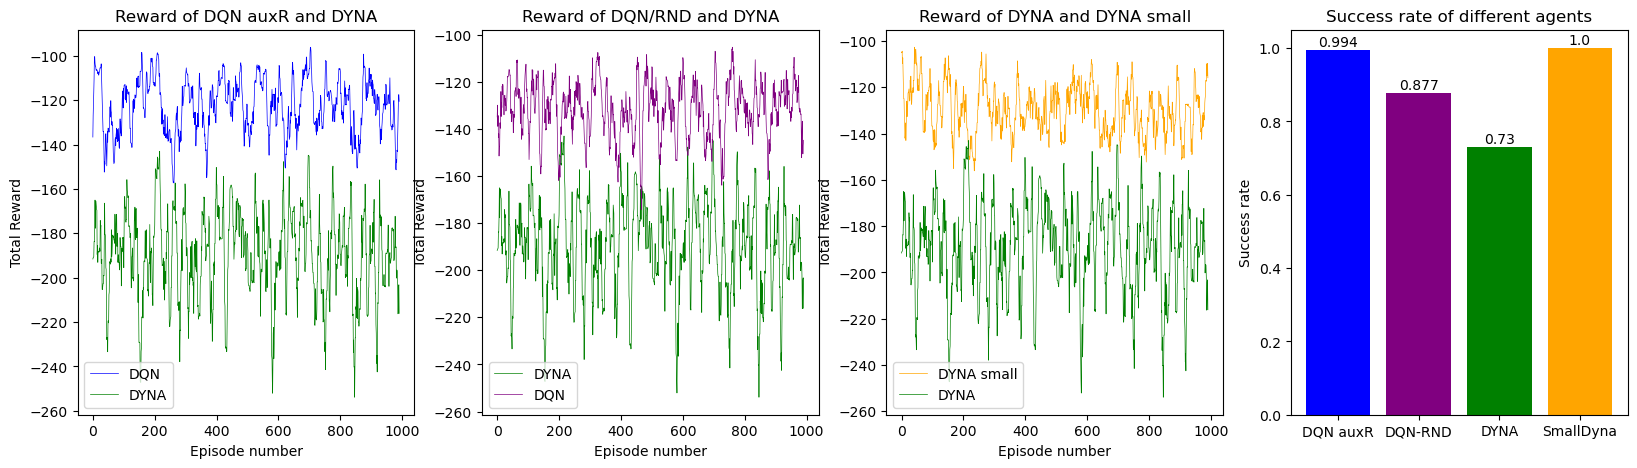

In [166]:

# plot the reward of agent
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

#DYNA_TEST
reward_dyna = np.load("test_rewards_dyna.npy")
reward_dyna = np.convolve(reward_dyna, np.ones(10)/10, mode='valid')
small_dyna = np.load("test_rewards_dyna_small.npy")
small_dyna = np.convolve(small_dyna, np.ones(10)/10, mode='valid')

# DQN with aux reward TEST
rewards = np.load("agents_saved/DQN_1000_episodes_aux_TEST/original_rewards.npy")[-1000:]
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[0].plot(rewards, color="blue", linewidth=0.5,label="DQN")
axs[0].plot(reward_dyna, color="green", linewidth=0.5,label="DYNA")
axs[0].legend()
axs[0].set_title("Reward of DQN auxR and DYNA")
axs[0].set_ylabel("Total Reward")
axs[0].set_xlabel("Episode number")

# DQN with RND TEST
rewards = np.load("agents_saved/DQN_1000_episodes_rnd_TEST/rewards.npy")[-1000:]
rewards = np.convolve(rewards, np.ones(10)/10, mode='valid')
axs[1].plot(reward_dyna, color="green", linewidth=0.5,label="DYNA")
axs[1].plot(rewards, color="purple", linewidth=0.5,label="DQN")
axs[1].legend()
axs[1].set_title("Reward of DQN/RND and DYNA")
axs[1].set_ylabel("Total Reward")
axs[1].set_xlabel("Episode number")

# DYNA TEST
axs[2].plot(small_dyna, color="orange", linewidth=0.5)
axs[2].plot(reward_dyna, color="green", linewidth=0.5)
axs[2].set_title("Reward of DYNA and DYNA small")
axs[2].set_ylabel("Total Reward")
axs[2].set_xlabel("Episode number")
axs[2].legend(["DYNA small", "DYNA"])


########### Success Plot ###########

successes_aux = np.load("agents_saved/DQN_1000_episodes_aux_TEST/dones.npy")[-1000:]
successes_rnd = np.load("agents_saved/DQN_1000_episodes_rnd_TEST/dones.npy")[-1000:]
success_dyna=(reward_dyna>=-200).astype(int)
success_small_dyna=(small_dyna>=-200).astype(int)

# count the percentage of successful episodes
success_rate_aux = np.sum(successes_aux) / len(successes_aux)
success_rate_rnd = np.sum(successes_rnd) / len(successes_rnd)
success_rate_dyna = np.sum(success_dyna) / len(success_dyna)
success_rate_small_dyna = np.sum(success_small_dyna) / len(success_small_dyna)

print(f"Success rate DQN with aux reward: {success_rate_aux}")
print(f"Success rate DQN with RND: {success_rate_rnd}")
print(f"Success rate DYNA: {success_rate_dyna}")
print(f"Success rate DYNA small: {success_rate_small_dyna}")

# create a barplot
labels = ['DQN auxR', 'DQN-RND', 'DYNA', 'SmallDyna']
success_rates = [success_rate_aux, success_rate_rnd, success_rate_dyna, success_rate_small_dyna]

axs[3].bar(labels, success_rates)
axs[3].set_ylabel('Success rate')
axs[3].set_title('Success rate of different agents')
axs[3].patches[0].set_facecolor('blue')
axs[3].patches[1].set_facecolor('purple')
axs[3].patches[2].set_facecolor('green')
axs[3].patches[3].set_facecolor('orange')

# ADD the success rate on the bars
for i, v in enumerate(success_rates):
    axs[3].text(i, v + 0.01, str(round(v, 3)), color='black', ha='center')
plt.show()

